In [3]:
import pandas as pd
import pickle
import numpy as np
import scipy.signal as sps
import matplotlib.pyplot as plt
import neurokit2 as nk
import seaborn as sns
from sklearn.linear_model import LogisticRegression

In [4]:
from preprocess import *

## Plotting raw signals

In [5]:
def plot_chest_signals(subject_idx, window_in_sec, shift_in_sec, samp_freq=700):
    
    window_size = int(round(window_in_sec * samp_freq))
    shift = int(round(shift_in_sec * samp_freq))
    
    with open(f'./WESAD/S{subject_idx}/S{subject_idx}.pkl', 'rb') as f:
        data = pickle.load(f, encoding="latin1")
    
    signal = data['signal']['chest']
    baseline_labels = data['label'] == 1
    stress_labels = data['label'] == 2
    
    baseline_signal = {}
    stress_signal = {}
    
    for k in signal:
        
        if k == 'ACC':
            continue
        else:
            baseline_signal[k] = signal[k][baseline_labels].squeeze()
            stress_signal[k] = signal[k][stress_labels].squeeze()
    
    baseline_mean, baseline_std = get_mean_std(baseline_signal, window_size, shift)
    stress_mean, stress_std = get_mean_std(stress_signal, window_size, shift)
    
#     print(baseline_mean)
    
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 14))
    plt.subplots_adjust(hspace=0.5) 
    axes = axes.reshape(5, 2)
    
    
    signal_names = list(baseline_mean.keys())
    
    for i in range(5):
        
        ax = axes[i, 0]
        mean_vals = baseline_mean[signal_names[i]]
        std_vals = baseline_std[signal_names[i]]
        ax.plot(np.arange(len(mean_vals)), mean_vals, color='blue')
        ax.fill_between(np.arange(len(mean_vals)), mean_vals-std_vals, mean_vals+std_vals, color='blue', alpha=0.21)
        
        ax = axes[i, 1]
        mean_vals = stress_mean[signal_names[i]]
        std_vals = stress_std[signal_names[i]]
        ax.plot(np.arange(len(mean_vals)), mean_vals, color='red')
        ax.fill_between(np.arange(len(mean_vals)), mean_vals-std_vals, mean_vals+std_vals, color='red', alpha=0.21)
        
        ax_left, ax_right = axes[i]
        row_x_center = (ax_left.get_position().x0 + ax_right.get_position().x1) / 2
        row_y_top = ax_left.get_position().y1  # top of the row (same for both axes)
        
        fig.text(row_x_center, row_y_top+0.01, signal_names[i],
             ha="center", va="bottom", fontsize=14)
        
#     plt.tight_layout()

            
def get_mean_std(signal, window_size, shift):
    
    sig_len = len(signal[list(signal.keys())[0]])
    start_idxs = np.arange(start=0, stop=sig_len-window_size, step=shift)
    
    signal_mean = {}
    signal_std = {}
    
    for k in signal:
        mean_vals = np.zeros(len(start_idxs))
        std_vals = np.zeros(len(start_idxs))
        
        for i, s_idx in enumerate(start_idxs):
            mean_vals[i] = np.mean(signal[k][s_idx:s_idx+window_size])
            std_vals[i] = np.std(signal[k][s_idx:s_idx+window_size])
        
        signal_mean[k] = mean_vals
        signal_std[k] = std_vals
    
    return signal_mean, signal_std

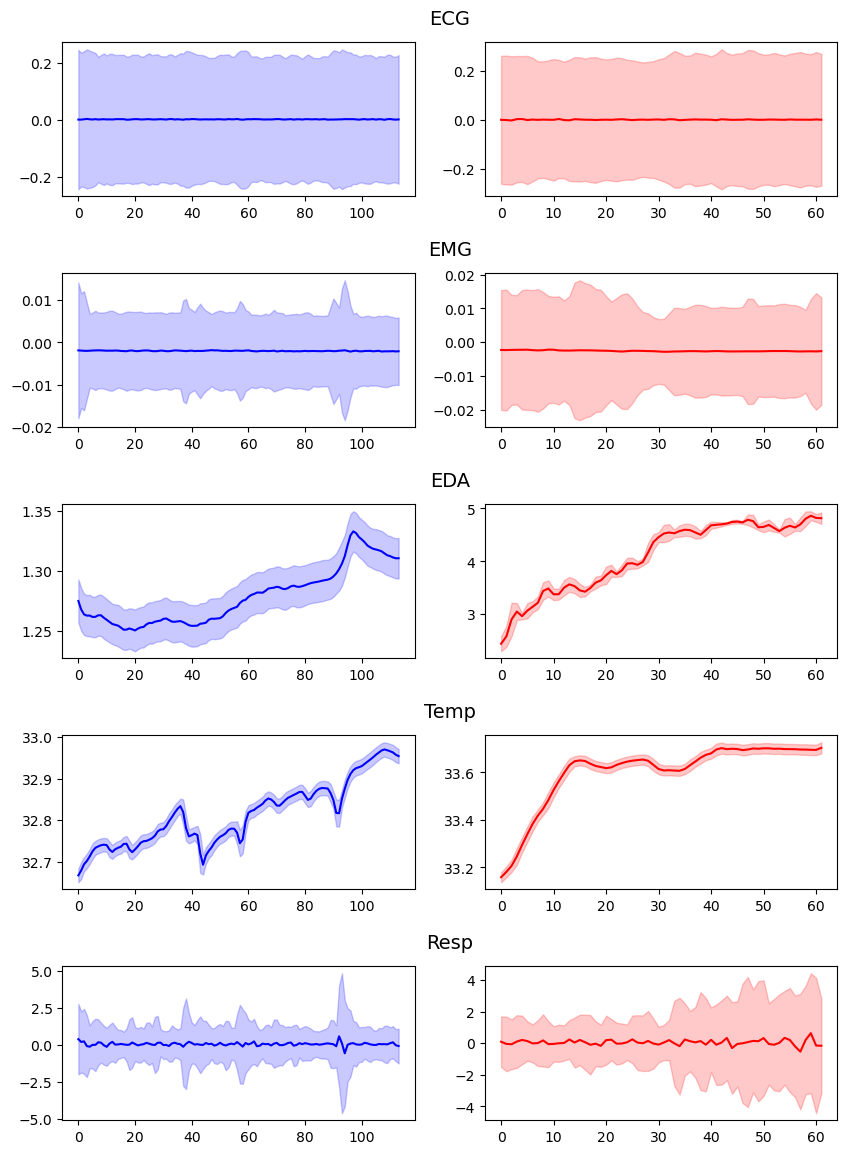

In [6]:
plot_chest_signals(4,20,10)

## Plotting feature correlation for chest features

In [5]:
feature_dict = {'EDA': {'SCL' : ['mean', 'std', 'slope'], 'SCR' : ['mean', 'max', 'counts']},
                'ECG' : ['mean_rate', 'std_rate', 'inter_peak_time', 'RMSSD', 'SDNN'],
                'Temp': ['mean', 'std', 'min','max', 'slope'],
                'Resp': {'Amp' : ['mean_rate', 'mean', 'std', 'SDNN'], 'RVT' : ['mean']}}

In [6]:
sampling_freq_dict = {'EDA': 700, 'ECG': 700, 'Temp': 700, 'Resp':700}

In [7]:
train_df_chest, test_data_list_chest = get_train_test_data(test_subjects=[14,15,16,17], modality='chest', window_in_sec=60, shift_in_sec=30, feature_dict=feature_dict, sampling_freq_dict=sampling_freq_dict, calibration_frac=0.25)

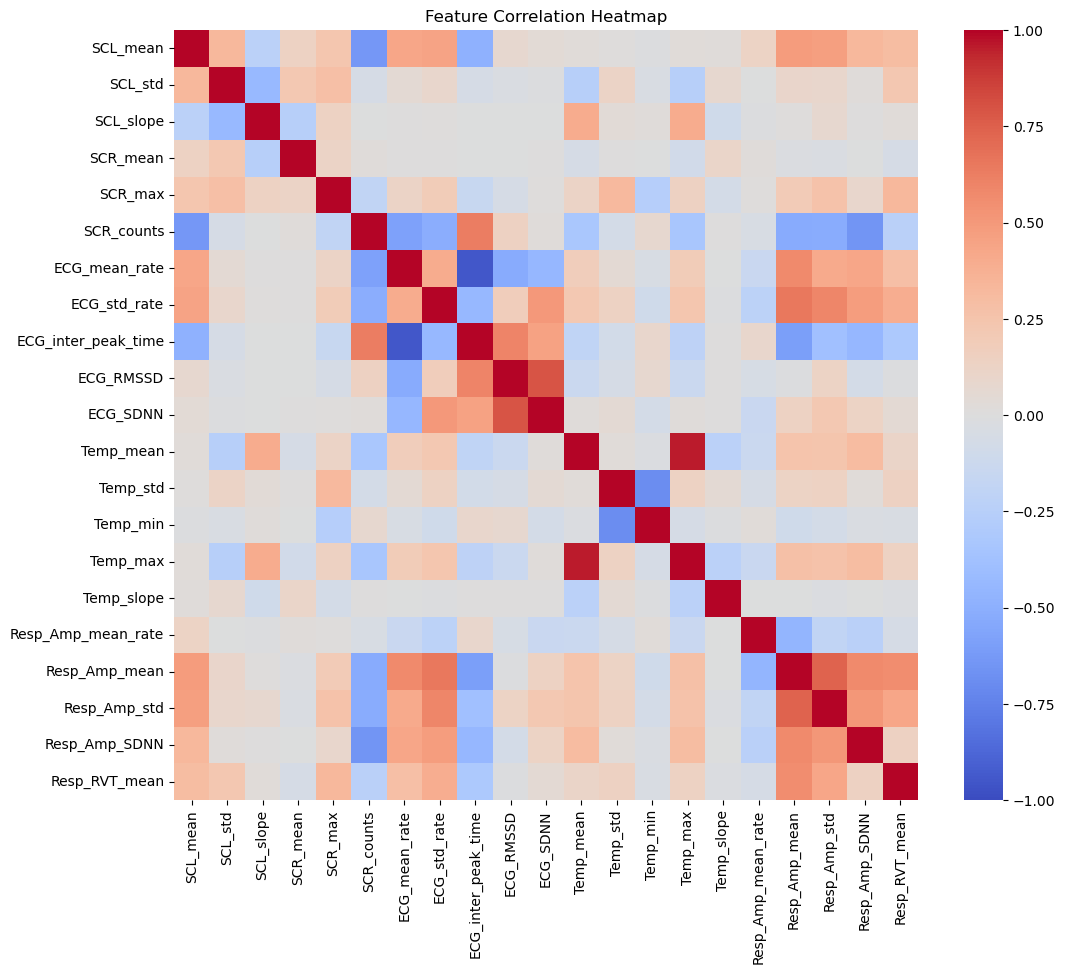

In [9]:
feature_cols = [c for c in train_df_chest.columns if c not in ['label']]
corr = train_df_chest[feature_cols].corr(method='pearson')

plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title("Feature Correlation Heatmap")
plt.show()

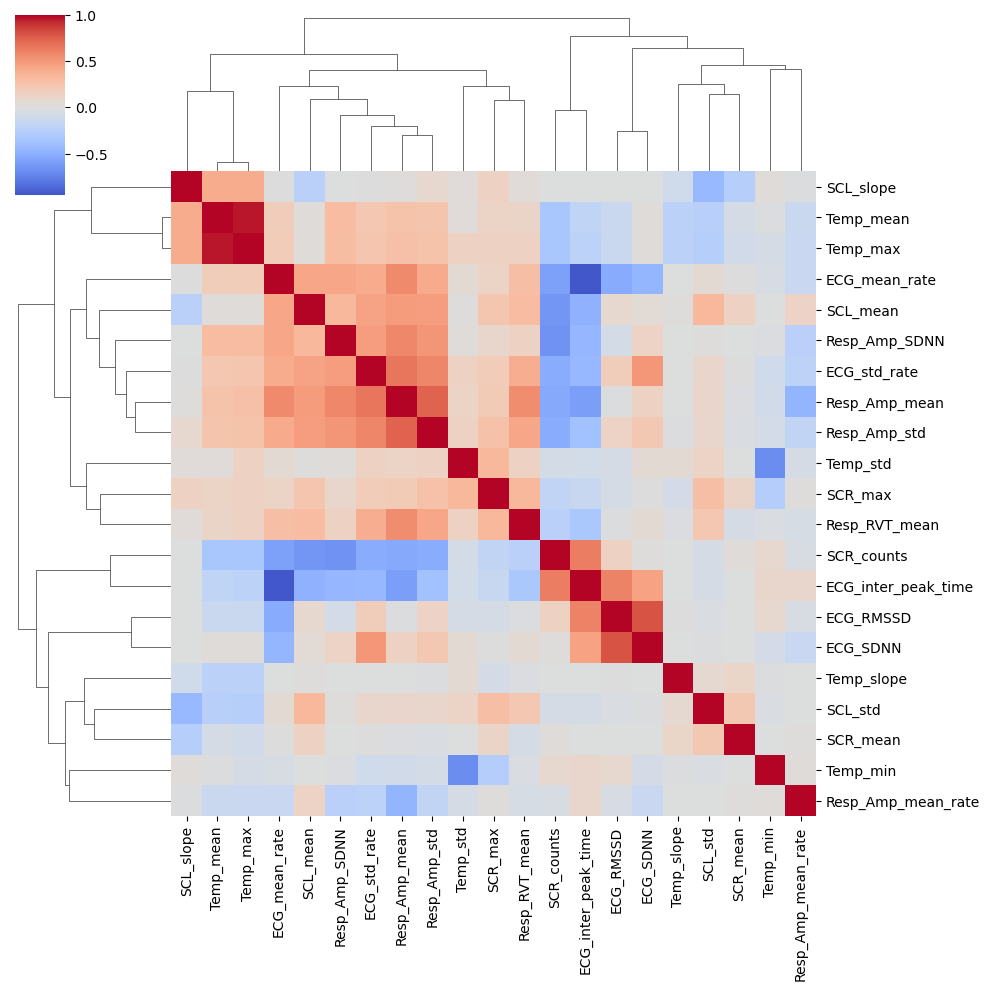

In [10]:
sns.clustermap(corr, cmap='coolwarm', center=0)

In [11]:
train_df_chest

,SCL_mean,SCL_std,SCL_slope,SCR_mean,SCR_max,SCR_counts,ECG_mean_rate,ECG_std_rate,ECG_inter_peak_time,ECG_RMSSD,...,Temp_std,Temp_min,Temp_max,Temp_slope,Resp_Amp_mean_rate,Resp_Amp_mean,Resp_Amp_std,Resp_Amp_SDNN,Resp_RVT_mean,label
0,2.853429,3.065776,-3.024450,2.707255e+00,0.871184,-1.633325,3.686080,3.032192,-3.382593,1.710364,...,-0.271154,0.685814,0.068059,-0.138684,-1.432890,3.096410,1.673365,1.609717,2.785509,0
1,2.425390,2.400401,-2.423510,4.846059e-01,0.273278,-1.390232,1.299463,2.439018,-1.175209,1.666335,...,-0.130094,0.472664,0.068059,-0.364526,0.656614,0.555195,0.404015,0.152293,2.654017,0
2,2.034788,2.236346,-2.250992,-1.555675e+00,-0.228746,-1.244375,-0.446886,0.850882,0.544053,-0.282757,...,-0.276747,0.337778,-0.102505,-0.218081,0.905007,-0.047369,-0.198579,0.050633,1.200804,0
3,1.706983,1.517265,-1.538846,-1.575928e+00,-0.234739,-1.001282,-0.955254,-0.520097,1.015289,-0.280138,...,-0.357774,0.314564,-0.186753,-0.061671,0.648547,-0.289387,-0.270519,-0.129283,0.100875,0
4,1.437950,1.163331,-1.114131,1.124686e+00,4.060259,-2.070893,1.095329,1.334711,-1.105472,1.324588,...,-0.362092,0.223996,-0.185877,-0.057326,1.477485,0.649852,0.653756,-0.408515,1.987318,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
634,1.925189,0.045934,-0.003109,-3.521697e-07,-0.005122,-12.736842,12.655700,0.737963,-87.773953,-4.805490,...,-0.006026,0.759257,0.747359,-0.000258,-4.282017,-0.653809,0.329456,-1106.399409,-0.284817,1
635,1.836628,0.037466,-0.002615,9.873595e-07,0.051794,-15.736842,12.475001,2.658824,-84.960542,-4.615105,...,-0.005823,0.765391,0.715224,-0.000326,1.613588,3.674339,3.489523,223.874479,-0.053963,1
636,1.816216,0.009958,0.000545,4.164029e-07,0.054337,-18.736842,12.680059,4.354268,-83.892495,3.530827,...,-0.004886,0.798930,0.715224,-0.000256,-2.209517,5.931008,6.970136,1900.390077,-0.184408,1
637,1.816053,0.010782,-0.000840,-8.848854e-07,-0.001484,-17.736842,9.431338,3.132358,-64.846839,13.136688,...,-0.006276,0.768382,0.725936,-0.000514,-4.328463,5.571271,-0.804660,100.677924,0.293593,1


## Plotting feature correlation for wrist features

In [12]:
feature_dict = {'BVP' : ['mean_rate', 'std_rate', 'inter_peak_time', 'RMSSD', 'SDNN'],
                'Temp': ['mean', 'std', 'min','max', 'slope']}

In [13]:
sampling_freq_dict = {'EDA' : 4, 'BVP':64, 'Temp':4}

In [14]:
train_df_wrist, test_data_list_wrist = get_train_test_data(test_subjects=[14,15,16,17], modality='wrist', window_in_sec=60, shift_in_sec=30, feature_dict=feature_dict, sampling_freq_dict=sampling_freq_dict, calibration_frac=0.25)

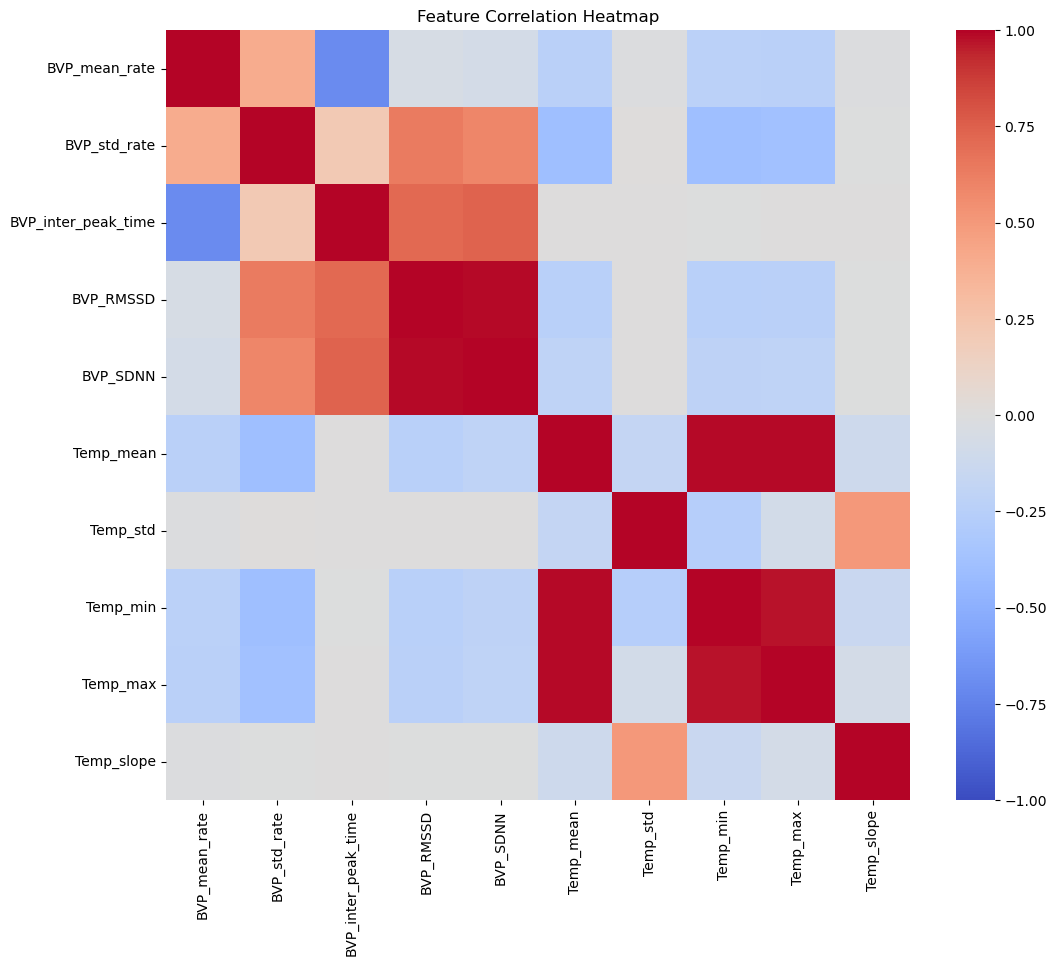

In [15]:
feature_cols = [c for c in train_df_wrist.columns if c not in ['label']]
corr = train_df_wrist[feature_cols].corr(method='pearson')

plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title("Feature Correlation Heatmap")
plt.show()

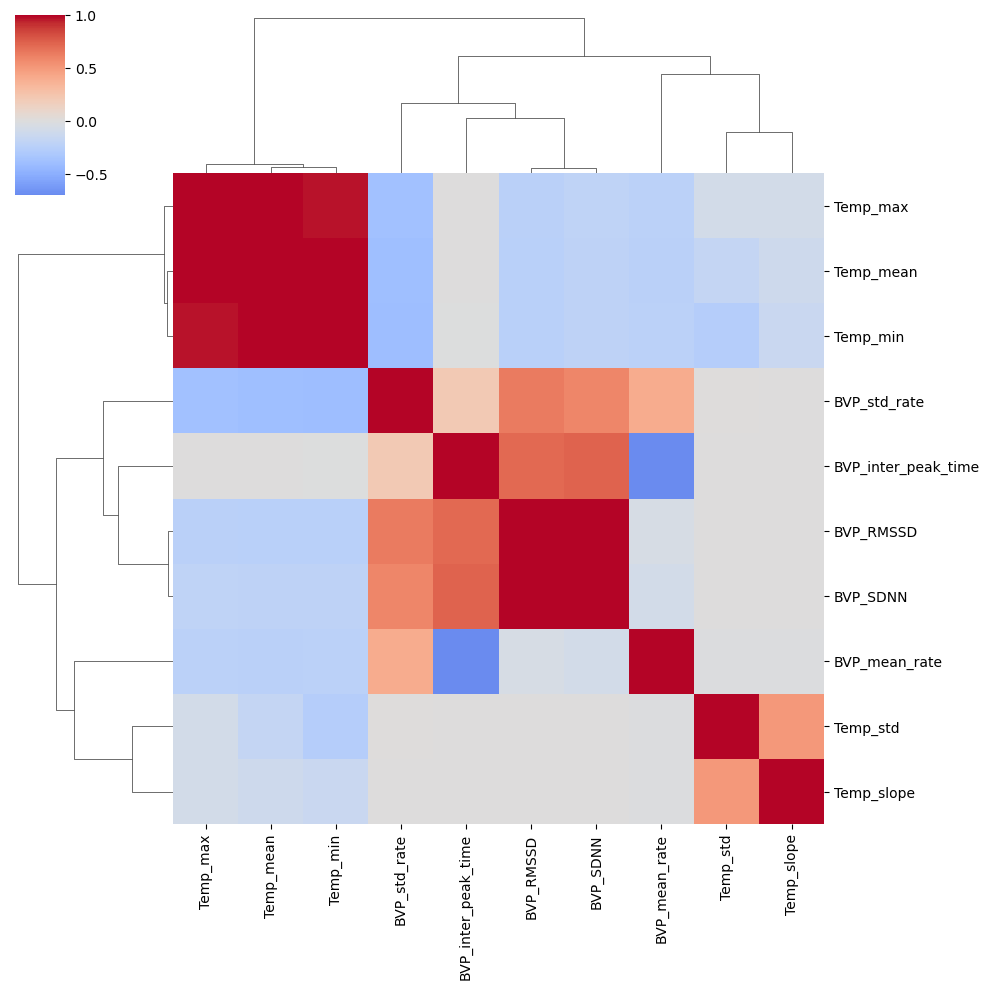

In [16]:
sns.clustermap(corr, cmap='coolwarm', center=0)

## Testing basic models with all features

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [39]:
def evaluate_performance(train_df, test_data_list, method, window_in_sec=60, shift_in_sec=30):
    feature_cols = [c for c in train_df.columns if c not in ['label']]
    X_train = train_df[feature_cols].values
    y_train = train_df['label'].values

    if method == 'LR':
        model = LogisticRegression(solver='liblinear', class_weight='balanced', max_iter=500, C=10.0)
    elif method == 'RF':
        model = RandomForestClassifier(n_estimators=30, class_weight="balanced", random_state=42)
    elif method == 'LDA':
        model = LinearDiscriminantAnalysis(solver="lsqr", shrinkage="auto")
    else:
        print('Method not supported')
        return
        

    model.fit(X_train, y_train)

    for test_df in test_data_list:
        y_pred = model.predict(test_df[feature_cols].values)
        y_true = test_df['label'].values
        y_prob = model.predict_proba(test_df[feature_cols].values)[:,1] if hasattr(model, "predict_proba") else model.decision_function(test_df[feature_cols].values)
        # print(f'F1_score: {f1_score(y_true, y_pred)}')
        print(f'AUC: {roc_auc_score(y_true, y_prob)}')
        print('Classification report:\n', classification_report(y_true, y_pred, digits=3))
        get_detection_delay(y_true, y_pred, window_in_sec, shift_in_sec)

In [40]:
def get_detection_delay(y_true, y_pred, window_in_sec, shift_in_sec, threshold=3):
    output_true = np.convolve(y_true, np.ones(threshold), mode='valid')
    output_pred = np.convolve(y_pred, np.ones(threshold), mode='valid')
    false_alarms = 0
    start_idx = -1
    detection_idx = -1
    false_alarm_flag = False

    for i in range(len(output_true)):
        if start_idx < 0 and output_true[i] == threshold:
            start_idx = i

        if output_pred[i] == threshold:
            if output_true[i] == threshold:
                detection_idx = i
                break
            else:
                if not false_alarm_flag:
                    false_alarms += 1
                    false_alarm_flag = True
        else:
            false_alarm_flag = False

    if detection_idx >= 0:
        detection_delay = threshold*window_in_sec - (threshold-1)*shift_in_sec + (detection_idx - start_idx)*shift_in_sec
        print(f'Stress onset was detected with a delay of {detection_delay} sec and with {false_alarms} false alarms.')
    else:
        print('No stress was detected')

#### Logistic Regression 

In [41]:
evaluate_performance(train_df_chest, test_data_list_chest, 'LR')

AUC: 1.0
Classification report:
               precision    recall  f1-score   support

           0      1.000     1.000     1.000        28
           1      1.000     1.000     1.000        21

    accuracy                          1.000        49
   macro avg      1.000     1.000     1.000        49
weighted avg      1.000     1.000     1.000        49

Stress onset was detected with a delay of 120 sec and with 0 false alarms.
AUC: 0.8605442176870748
Classification report:
               precision    recall  f1-score   support

           0      0.824     1.000     0.903        28
           1      1.000     0.714     0.833        21

    accuracy                          0.878        49
   macro avg      0.912     0.857     0.868        49
weighted avg      0.899     0.878     0.873        49

Stress onset was detected with a delay of 120 sec and with 0 false alarms.
AUC: 1.0
Classification report:
               precision    recall  f1-score   support

           0      1.000    

In [42]:
evaluate_performance(train_df_wrist, test_data_list_wrist, 'LR')

AUC: 1.0
Classification report:
               precision    recall  f1-score   support

           0      1.000     0.857     0.923        28
           1      0.840     1.000     0.913        21

    accuracy                          0.918        49
   macro avg      0.920     0.929     0.918        49
weighted avg      0.931     0.918     0.919        49

Stress onset was detected with a delay of 120 sec and with 0 false alarms.
AUC: 0.20578231292517007
Classification report:
               precision    recall  f1-score   support

           0      0.591     0.929     0.722        28
           1      0.600     0.143     0.231        21

    accuracy                          0.592        49
   macro avg      0.595     0.536     0.476        49
weighted avg      0.595     0.592     0.512        49

No stress was detected
AUC: 1.0
Classification report:
               precision    recall  f1-score   support

           0      1.000     1.000     1.000        28
           1      1.000 

#### Random Forests 

In [43]:
evaluate_performance(train_df_chest, test_data_list_chest, 'RF')

AUC: 1.0
Classification report:
               precision    recall  f1-score   support

           0      1.000     1.000     1.000        28
           1      1.000     1.000     1.000        21

    accuracy                          1.000        49
   macro avg      1.000     1.000     1.000        49
weighted avg      1.000     1.000     1.000        49

Stress onset was detected with a delay of 120 sec and with 0 false alarms.
AUC: 0.9999999999999999
Classification report:
               precision    recall  f1-score   support

           0      0.933     1.000     0.966        28
           1      1.000     0.905     0.950        21

    accuracy                          0.959        49
   macro avg      0.967     0.952     0.958        49
weighted avg      0.962     0.959     0.959        49

Stress onset was detected with a delay of 120 sec and with 0 false alarms.
AUC: 1.0
Classification report:
               precision    recall  f1-score   support

           0      1.000    

In [44]:
evaluate_performance(train_df_wrist, test_data_list_wrist, 'RF')

AUC: 1.0
Classification report:
               precision    recall  f1-score   support

           0      1.000     0.929     0.963        28
           1      0.913     1.000     0.955        21

    accuracy                          0.959        49
   macro avg      0.957     0.964     0.959        49
weighted avg      0.963     0.959     0.959        49

Stress onset was detected with a delay of 120 sec and with 0 false alarms.
AUC: 1.0
Classification report:
               precision    recall  f1-score   support

           0      1.000     1.000     1.000        28
           1      1.000     1.000     1.000        21

    accuracy                          1.000        49
   macro avg      1.000     1.000     1.000        49
weighted avg      1.000     1.000     1.000        49

Stress onset was detected with a delay of 120 sec and with 0 false alarms.
AUC: 1.0
Classification report:
               precision    recall  f1-score   support

           0      1.000     0.929     0.96

#### Linear Discriminant Analysis

In [45]:
evaluate_performance(train_df_chest, test_data_list_chest, 'LDA')

AUC: 1.0
Classification report:
               precision    recall  f1-score   support

           0      0.966     1.000     0.982        28
           1      1.000     0.952     0.976        21

    accuracy                          0.980        49
   macro avg      0.983     0.976     0.979        49
weighted avg      0.980     0.980     0.980        49

Stress onset was detected with a delay of 120 sec and with 0 false alarms.
AUC: 0.7329931972789117
Classification report:
               precision    recall  f1-score   support

           0      0.667     1.000     0.800        28
           1      1.000     0.333     0.500        21

    accuracy                          0.714        49
   macro avg      0.833     0.667     0.650        49
weighted avg      0.810     0.714     0.671        49

No stress was detected
AUC: 1.0
Classification report:
               precision    recall  f1-score   support

           0      1.000     1.000     1.000        28
           1      1.000  

In [46]:
evaluate_performance(train_df_wrist, test_data_list_wrist, 'LDA')

AUC: 1.0
Classification report:
               precision    recall  f1-score   support

           0      1.000     1.000     1.000        28
           1      1.000     1.000     1.000        21

    accuracy                          1.000        49
   macro avg      1.000     1.000     1.000        49
weighted avg      1.000     1.000     1.000        49

Stress onset was detected with a delay of 120 sec and with 0 false alarms.
AUC: 0.7125850340136054
Classification report:
               precision    recall  f1-score   support

           0      0.700     1.000     0.824        28
           1      1.000     0.429     0.600        21

    accuracy                          0.755        49
   macro avg      0.850     0.714     0.712        49
weighted avg      0.829     0.755     0.728        49

Stress onset was detected with a delay of 120 sec and with 0 false alarms.
AUC: 1.0
Classification report:
               precision    recall  f1-score   support

           0      1.000    